In [2]:
import pandas as pd
import numpy as np

# Dataset Ingestion

In [3]:
cols = {0: 'pseudo', 1: 'code'}

train_df = pd.read_csv('../data/input-tok-train-shuf.tsv', header=None, delimiter='\t')
train_df.rename(columns=cols, inplace=True)

train_df['pseudo_token'] = train_df['pseudo'].str.split(' ')
train_df['code_token'] = train_df['code'].str.split(' ')
train_df.head()

,pseudo,code,pseudo_token,code_token
0,set l to mid,l = mid ;,"[set, l, to, mid]","[l, =, mid, ;]"
1,if i is 0,if ( i == 0 ),"[if, i, is, 0]","[if, (, i, ==, 0, )]"
2,read n and k,cin >> n >> k ;,"[read, n, and, k]","[cin, >>, n, >>, k, ;]"
3,declare long longs sum = 0 and min = LONG_LONG...,"long long min = LONG_LONG_MAX , sum = 0 ;","[declare, long, longs, sum, =, 0, and, min, =,...","[long, long, min, =, LONG_LONG_MAX, ,, sum, =,..."
4,dy = integer array where the the following int...,"int dy [ ] = { 0 , 0 , - 1 , 1 } ;","[dy, =, integer, array, where, the, the, follo...","[int, dy, [, ], =, {, 0, ,, 0, ,, -, 1, ,, 1, ..."


In [4]:
def create_copy_gen_seq_from_pseudo_row(row):
    """
    Returns binary sequence for pseudocode tokens based on 
    true code tokens

    If the pseudocode token exists in the true code (can be
    copied), then the sequence contains a 1 in that position
    """
    code_token_set = set(row['code_token'])
    output_seq = []
    generate_seq = []

    for token in row['pseudo_token']:
        if token in code_token_set:
            output_seq.append(1)
            generate_seq.append('[CPY]')
        else:
            output_seq.append(0)
            generate_seq.append(token)

    # generate_seq.append('[END]')
    assert len(output_seq) == len(row['pseudo_token'])
    return (output_seq, generate_seq)

In [5]:
seqs = train_df.apply(create_copy_gen_seq_from_pseudo_row, axis=1)
code_binary_seq = [x[0] for x in seqs]
generate_seq = [x[1] for x in seqs]
train_df['pseudo_copy_seq'] = code_binary_seq
train_df['pseudo_gen_seq'] = generate_seq
train_df

,pseudo,code,pseudo_token,code_token,pseudo_copy_seq,pseudo_gen_seq
0,set l to mid,l = mid ;,"[set, l, to, mid]","[l, =, mid, ;]","[0, 1, 0, 1]","[set, [CPY], to, [CPY]]"
1,if i is 0,if ( i == 0 ),"[if, i, is, 0]","[if, (, i, ==, 0, )]","[1, 1, 0, 1]","[[CPY], [CPY], is, [CPY]]"
2,read n and k,cin >> n >> k ;,"[read, n, and, k]","[cin, >>, n, >>, k, ;]","[0, 1, 0, 1]","[read, [CPY], and, [CPY]]"
3,declare long longs sum = 0 and min = LONG_LONG...,"long long min = LONG_LONG_MAX , sum = 0 ;","[declare, long, longs, sum, =, 0, and, min, =,...","[long, long, min, =, LONG_LONG_MAX, ,, sum, =,...","[0, 1, 0, 1, 1, 1, 0, 1, 1, 1]","[declare, [CPY], longs, [CPY], [CPY], [CPY], a..."
4,dy = integer array where the the following int...,"int dy [ ] = { 0 , 0 , - 1 , 1 } ;","[dy, =, integer, array, where, the, the, follo...","[int, dy, [, ], =, {, 0, ,, 0, ,, -, 1, ,, 1, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[[CPY], [CPY], integer, array, where, the, the..."
...,...,...,...,...,...,...
181857,declare static constant integer mod = 1000000009,static const int mod = 1000000009 ;,"[declare, static, constant, integer, mod, =, 1...","[static, const, int, mod, =, 1000000009, ;]","[0, 1, 0, 0, 1, 1, 1]","[declare, [CPY], constant, integer, [CPY], [CP..."
181858,print NO and a new line,"cout << "" NO "" << ' \n ' ;","[print, NO, and, a, new, line]","[cout, <<, "", NO, "", <<, ', \n, ', ;]","[0, 1, 0, 0, 0, 0]","[print, [CPY], and, a, new, line]"
181859,change the value of ans to abs ( x - y ) / d,ans = abs ( x - y ) / d ;,"[change, the, value, of, ans, to, abs, (, x, -...","[ans, =, abs, (, x, -, y, ), /, d, ;]","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]","[change, the, value, of, [CPY], to, [CPY], [CP..."
181860,else if s is less than f,else if ( s < f ),"[else, if, s, is, less, than, f]","[else, if, (, s, <, f, )]","[1, 1, 1, 0, 0, 0, 1]","[[CPY], [CPY], [CPY], is, less, than, [CPY]]"


In [6]:
def create_gen_seq_from_code_row(row):
    """
    Returns binary sequence for pseudocode tokens based on 
    true code tokens

    If the pseudocode token exists in the true code (can be
    copied), then the sequence contains a 1 in that position
    """
    pseudo_token_set = set(row['pseudo_token'])
    gen_code_seq = []

    # for i, token in enumerate(row['code_token']):
    for token in row['code_token']:
        # if i == 0:
        #     gen_code_seq.append('[START]')
        # elif i == len(row['code_token']):
        #     gen_code_seq.append('[END]')

        if token in pseudo_token_set:
            gen_code_seq.append('[CPY]')
        else:
            gen_code_seq.append(token)

    return gen_code_seq

In [7]:
gen_code_seq = train_df.apply(create_gen_seq_from_code_row, axis=1)
train_df['code_gen_seq'] = gen_code_seq
train_df

,pseudo,code,pseudo_token,code_token,pseudo_copy_seq,pseudo_gen_seq,code_gen_seq
0,set l to mid,l = mid ;,"[set, l, to, mid]","[l, =, mid, ;]","[0, 1, 0, 1]","[set, [CPY], to, [CPY]]","[[CPY], =, [CPY], ;]"
1,if i is 0,if ( i == 0 ),"[if, i, is, 0]","[if, (, i, ==, 0, )]","[1, 1, 0, 1]","[[CPY], [CPY], is, [CPY]]","[[CPY], (, [CPY], ==, [CPY], )]"
2,read n and k,cin >> n >> k ;,"[read, n, and, k]","[cin, >>, n, >>, k, ;]","[0, 1, 0, 1]","[read, [CPY], and, [CPY]]","[cin, >>, [CPY], >>, [CPY], ;]"
3,declare long longs sum = 0 and min = LONG_LONG...,"long long min = LONG_LONG_MAX , sum = 0 ;","[declare, long, longs, sum, =, 0, and, min, =,...","[long, long, min, =, LONG_LONG_MAX, ,, sum, =,...","[0, 1, 0, 1, 1, 1, 0, 1, 1, 1]","[declare, [CPY], longs, [CPY], [CPY], [CPY], a...","[[CPY], [CPY], [CPY], [CPY], [CPY], ,, [CPY], ..."
4,dy = integer array where the the following int...,"int dy [ ] = { 0 , 0 , - 1 , 1 } ;","[dy, =, integer, array, where, the, the, follo...","[int, dy, [, ], =, {, 0, ,, 0, ,, -, 1, ,, 1, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[[CPY], [CPY], integer, array, where, the, the...","[int, [CPY], [CPY], [CPY], [CPY], {, [CPY], [C..."
...,...,...,...,...,...,...,...
181857,declare static constant integer mod = 1000000009,static const int mod = 1000000009 ;,"[declare, static, constant, integer, mod, =, 1...","[static, const, int, mod, =, 1000000009, ;]","[0, 1, 0, 0, 1, 1, 1]","[declare, [CPY], constant, integer, [CPY], [CP...","[[CPY], const, int, [CPY], [CPY], [CPY], ;]"
181858,print NO and a new line,"cout << "" NO "" << ' \n ' ;","[print, NO, and, a, new, line]","[cout, <<, "", NO, "", <<, ', \n, ', ;]","[0, 1, 0, 0, 0, 0]","[print, [CPY], and, a, new, line]","[cout, <<, "", [CPY], "", <<, ', \n, ', ;]"
181859,change the value of ans to abs ( x - y ) / d,ans = abs ( x - y ) / d ;,"[change, the, value, of, ans, to, abs, (, x, -...","[ans, =, abs, (, x, -, y, ), /, d, ;]","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]","[change, the, value, of, [CPY], to, [CPY], [CP...","[[CPY], =, [CPY], [CPY], [CPY], [CPY], [CPY], ..."
181860,else if s is less than f,else if ( s < f ),"[else, if, s, is, less, than, f]","[else, if, (, s, <, f, )]","[1, 1, 1, 0, 0, 0, 1]","[[CPY], [CPY], [CPY], is, less, than, [CPY]]","[[CPY], [CPY], (, [CPY], <, [CPY], )]"


In [8]:
train_df['code_gen_seq_aug'] = train_df['code_gen_seq'].apply(lambda x: ['[START]'] + x + ['[STOP]'])
train_df

,pseudo,code,pseudo_token,code_token,pseudo_copy_seq,pseudo_gen_seq,code_gen_seq,code_gen_seq_aug
0,set l to mid,l = mid ;,"[set, l, to, mid]","[l, =, mid, ;]","[0, 1, 0, 1]","[set, [CPY], to, [CPY]]","[[CPY], =, [CPY], ;]","[[START], [CPY], =, [CPY], ;, [STOP]]"
1,if i is 0,if ( i == 0 ),"[if, i, is, 0]","[if, (, i, ==, 0, )]","[1, 1, 0, 1]","[[CPY], [CPY], is, [CPY]]","[[CPY], (, [CPY], ==, [CPY], )]","[[START], [CPY], (, [CPY], ==, [CPY], ), [STOP]]"
2,read n and k,cin >> n >> k ;,"[read, n, and, k]","[cin, >>, n, >>, k, ;]","[0, 1, 0, 1]","[read, [CPY], and, [CPY]]","[cin, >>, [CPY], >>, [CPY], ;]","[[START], cin, >>, [CPY], >>, [CPY], ;, [STOP]]"
3,declare long longs sum = 0 and min = LONG_LONG...,"long long min = LONG_LONG_MAX , sum = 0 ;","[declare, long, longs, sum, =, 0, and, min, =,...","[long, long, min, =, LONG_LONG_MAX, ,, sum, =,...","[0, 1, 0, 1, 1, 1, 0, 1, 1, 1]","[declare, [CPY], longs, [CPY], [CPY], [CPY], a...","[[CPY], [CPY], [CPY], [CPY], [CPY], ,, [CPY], ...","[[START], [CPY], [CPY], [CPY], [CPY], [CPY], ,..."
4,dy = integer array where the the following int...,"int dy [ ] = { 0 , 0 , - 1 , 1 } ;","[dy, =, integer, array, where, the, the, follo...","[int, dy, [, ], =, {, 0, ,, 0, ,, -, 1, ,, 1, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[[CPY], [CPY], integer, array, where, the, the...","[int, [CPY], [CPY], [CPY], [CPY], {, [CPY], [C...","[[START], int, [CPY], [CPY], [CPY], [CPY], {, ..."
...,...,...,...,...,...,...,...,...
181857,declare static constant integer mod = 1000000009,static const int mod = 1000000009 ;,"[declare, static, constant, integer, mod, =, 1...","[static, const, int, mod, =, 1000000009, ;]","[0, 1, 0, 0, 1, 1, 1]","[declare, [CPY], constant, integer, [CPY], [CP...","[[CPY], const, int, [CPY], [CPY], [CPY], ;]","[[START], [CPY], const, int, [CPY], [CPY], [CP..."
181858,print NO and a new line,"cout << "" NO "" << ' \n ' ;","[print, NO, and, a, new, line]","[cout, <<, "", NO, "", <<, ', \n, ', ;]","[0, 1, 0, 0, 0, 0]","[print, [CPY], and, a, new, line]","[cout, <<, "", [CPY], "", <<, ', \n, ', ;]","[[START], cout, <<, "", [CPY], "", <<, ', \n, ',..."
181859,change the value of ans to abs ( x - y ) / d,ans = abs ( x - y ) / d ;,"[change, the, value, of, ans, to, abs, (, x, -...","[ans, =, abs, (, x, -, y, ), /, d, ;]","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]","[change, the, value, of, [CPY], to, [CPY], [CP...","[[CPY], =, [CPY], [CPY], [CPY], [CPY], [CPY], ...","[[START], [CPY], =, [CPY], [CPY], [CPY], [CPY]..."
181860,else if s is less than f,else if ( s < f ),"[else, if, s, is, less, than, f]","[else, if, (, s, <, f, )]","[1, 1, 1, 0, 0, 0, 1]","[[CPY], [CPY], [CPY], is, less, than, [CPY]]","[[CPY], [CPY], (, [CPY], <, [CPY], )]","[[START], [CPY], [CPY], (, [CPY], <, [CPY], ),..."


### Get Vocabulary of pseudocode and code

In [9]:
def get_vocab(column_name):
    vocab = set()
    for line in train_df[column_name]:
        for token in line:
            vocab.add(token) 
    return vocab

In [10]:
def get_max_len(column_name):
    maxlist = max(train_df[column_name], key=len)
    return len(maxlist)

In [11]:
# pseudo_vocab = set() 
# for line in train_df['pseudo_token']:
#     for token in line:
#         pseudo_vocab.add(token) 

# code_vocab = set() 
# for line in train_df['code_token']:
#     for token in line:
#         code_vocab.add(token)

# pseudo_vocab = set() 
# for line in train_df['pseudo_token']:
#     for token in line:
#         pseudo_vocab.add(token) 

In [12]:
pseudo_vocab = get_vocab('pseudo_token')
pseudo_gen_vocab = get_vocab('pseudo_gen_seq')
num_pseudo_tokens = len(pseudo_vocab)
num_pseudo_gen_tokens = len(pseudo_gen_vocab)

In [13]:
code_vocab = get_vocab('code_token')
code_gen_vocab = get_vocab('code_gen_seq')
code_gen_aug_vocab = get_vocab('code_gen_seq_aug')
num_code_tokens = len(code_vocab)
num_code_gen_tokens = len(code_gen_vocab)
num_code_gen_aug_tokens = len(code_gen_aug_vocab)

In [14]:
code_gen_vocab = sorted(list(code_gen_vocab))
code_gen_vocab.index('[CPY]')

436

In [15]:
max_pseudo_gen = get_max_len('pseudo_gen_seq')
max_code_gen = get_max_len('code_gen_seq')
max_code_gen_aug = get_max_len('code_gen_seq_aug')

## Make Indexes for each word

In [16]:
input_words = sorted(list(pseudo_gen_vocab))
output_words = sorted(list(code_gen_aug_vocab))

In [17]:
pseudo_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
code_token_index = dict([(word, i+1) for i, word in enumerate(output_words)])

reverse_pseudo_index = dict((i, word) for word, i in pseudo_token_index.items())
reverse_code_index = dict((i, word) for word, i in code_token_index.items())

# Define Seq2Seq model

In [18]:
num_encoder_tokens = num_pseudo_gen_tokens
latent_dim = 50 
num_decoder_tokens = num_code_gen_aug_tokens + 1 
# +1 because of 0 padding. No. of tokens = 1078 but the index starts from 1 not from 0 so add 1

### Seq2Seq learning for generation

#### Define Placeholders for the input tensors

In [19]:
len(train_df['pseudo_gen_seq'])
len(train_df['code_gen_seq_aug'])

181862

In [20]:
encoder_input_data = np.zeros((len(train_df['pseudo_gen_seq']), max_pseudo_gen), dtype='float32')
decoder_input_data = np.zeros((len(train_df['code_gen_seq_aug']), max_code_gen_aug), dtype='float32')
decoder_target_data = np.zeros((len(train_df['code_gen_seq_aug']), max_code_gen_aug, num_decoder_tokens), dtype='float32')

In [21]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(181862, 85)
(181862, 87)
(181862, 87, 1079)


In [22]:
for i, (input_seq, target_seq) in enumerate(zip(train_df['pseudo_gen_seq'], train_df['code_gen_seq_aug'])):
    # print(input_text, target_text)
    for t, word in enumerate(input_seq):
        encoder_input_data[i, t] = pseudo_token_index[word]
    for t, word in enumerate(target_seq):
        # print(t, word)
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = code_token_index[word]   
        # print(word, code_token_index[word])
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, code_token_index[word]] = 1.

In [23]:
encoder_input_data = encoder_input_data[:10000]
decoder_input_data = decoder_input_data[:10000]
decoder_target_data = decoder_target_data[:10000]

In [24]:
# count = 0
# count2 = 0
# count3 = 0
# for i in decoder_target_data:
#     for j in i:
#         count3 += j.count(1)
#         if(1 in j):
#             count += 1
#         count2 += 1

In [25]:
# (count2 - count)/ count2 * 100

In [26]:
from keras.layers import Input, Embedding, LSTM, Dense 
from keras import Model
from tensorflow.keras.utils import plot_model

In [27]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
en_x = Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
en_out, state_h, state_c = LSTM(latent_dim, return_state=True)(en_x)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
de_x = dec_emb_layer(decoder_inputs)
# de_x = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_lstm_layer = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _ , _ = dec_lstm_layer(de_x, initial_state=encoder_states)

dec_dense_layer = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = dec_dense_layer(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile & run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!

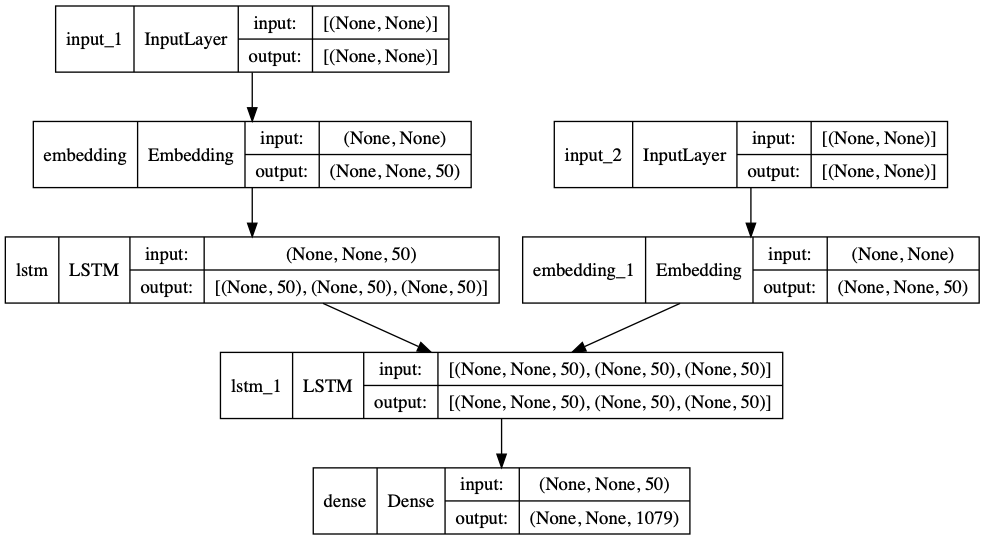

In [28]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=10000,
          epochs=50,
          validation_split=0.2)

### Inference

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = dec_lstm_layer(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = dec_dense_layer(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = code_token_index['[START]']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    # decoded_sentence = ''
    decoded_sentence = []
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_code_index[sampled_token_index]
        # decoded_sentence += ' '+sampled_char
        decoded_sentence.append(sampled_char)
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == '[STOP]' or len(decoded_sentence) > 50):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        states_value = [h, c]
    
    return decoded_sentence

In [ ]:
for seq_index in [500, 100]:
    # print(encoder_input_data[seq_index])
    input_seq = encoder_input_data[seq_index: seq_index+1]
    # print(input_seq)
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', train_df['pseudo_gen_seq'][seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)